In [164]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
from scipy import special as ssp # fonction gamma
%matplotlib inline

# Calcul de Ff

In [165]:
def fourier_inverse(X,Xi,Ff):
    return (Xi[1]-Xi[0])*np.array([np.sum(Ff*np.exp(1j*x*Xi)) for x in X])/(2*np.pi)

def get_fourier_log_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*np.log(Wt[Wt>0]))) for xi in Xi]

In [166]:
def get_axi(wt,ximin,ximax,nbreaks_xi,tmax):
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot_four = ([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    tot_abs = np.log(np.abs(tot_four))
    tot_ang = np.angle(tot_four)
        
    # régression linéaire:
    res=[]
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot_abs)[:,k])
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(range(tmax),np.real(tot_ang)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        res+=[(Xi[k],slope,slope2,r_value,r_value2)]
        #print("pente :",slope, "\tpente angle :",slope2)
    # affichage:
    #plt.plot(range(tmax),tot_abs)
    #plt.grid()
    #plt.legend(["xi="+str(xi) for xi in Xi])
    #plt.xlabel("t")
    #plt.ylabel("ln[Fu_t(xi)]")
    #plt.title(titre)
    #plt.show() 
    return np.array(res)

# Calcul effectif de la DFE

In [167]:
xmin_reel=-2
xmax_reel=0.999
nbreaks_x=100
x=np.linspace(xmin_reel,xmax_reel,nbreaks_x)
lnx=np.log(1-x)

In [168]:
lambd=0.32/60 # constante biologique = taux de mutation

In [169]:
ncells=60000 # nombre de cellules utilisées pour les simulations
nreplicats=3 # nombre de simulations

La fonction suivante applique la formule de la dfe trouvée avec l'edp :

In [170]:
def get_dfe(wt,lnx,lambd,ximin,ximax,nbreaks_xi,tmax):
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(wt,ximin,ximax,nbreaks_xi,tmax).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    
    y=fourier_inverse(lnx,Xi,Ff)
    return y

# Réplications sur différentes simulations

- Distribution initiale des taux de croissances

In [171]:
data = "cleaned"    # "raw" data or "cleaned" data (without dead cells and aberrant growth rates)

if data == "raw":
    file="Donnees_article/All_data/data_microMA/dataset_microMA_MutH.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",", 
                          usecols=range(2,1476*3+1,3), 
                          skiprows=[1,2])

elif data == "cleaned":
    file="Donnees_article_modifiees/data_microMA/dataset_microMA_MutH_growthRates_NAdead_NAab.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",",
                          index_col=0)

growthR_real = growthR_real.to_numpy()

In [172]:
growthR_init = [np.median([l for l in d if not np.isnan(l)]) for d in growthR_real.T[:,:10]]   # médiane des 10 premières mesures

# on augmente la taille de growthR_init:
growthR_init=growthR_init*100
growthR_init=np.array(growthR_init[:ncells])

growthR_init[growthR_init<0] = 0          # retirer la valeur de taux de croissance négative aberrante
growthR_init[np.isnan(growthR_init)] = 0          # retirer les nan

/usr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- Paramètres utilisés pour la simulation

In [173]:
# Générer des mutations
mutation_rate = 0.32/60   # nombre de mutations par minute, estimation pour mutH (mutH: ~0.32 mutation/heure)
#exp_duration = 1000         # durée de l'expérience, en minutes // modifié pour être plus rapide !
exp_duration = 100
mut_shape = (50+int(exp_duration*mutation_rate), ncells)  # nombre de mutations à tirer dans chacun des 1476 canaux de l'expérience
lethal_mut_proba = 0.01   # fraction de mutation létales (estimée à 1% dans l'article)
constant_mut_rate = False # on choisit si le taux de mutation est constant

# Temps de mesure des taux de croissance, comme dans l'article (toutes les 4 minutes sur 4000 minutes)
time = np.arange(0, exp_duration+1, 4, dtype=float)

# Bruit sur les mesures
sd_noise = 0.15           # Écart-type bruit additif gaussien

- Tirer dans une DFE donnée l'effet relatif de chacune des mutations sur le taux de croissance

In [174]:
# rappel des valeurs de l'article
#alpha=0.0074
#beta=2.4



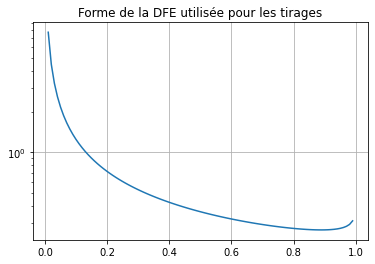

In [175]:

# PARAMÈTRES TESTS

alpha=0.2
beta=0.9

zar=np.linspace(0.01,0.99,100)
plt.yscale('log')
plt.grid()
plt.title("Forme de la DFE utilisée pour les tirages")
dfe_reelle_sim=[z**(alpha-1)*(1-z)**(beta-1)*ssp.gamma(alpha+beta)/(ssp.gamma(alpha)*ssp.gamma(beta)) for z in zar]
plt.plot(zar,dfe_reelle_sim)
plt.show()

- Fonctions réalisant la simulation

In [176]:
def average_by_generation(growthR, sd_noise=0):
    # Cumulative growth of the cell (exponential coefficient = growth rate x (nbPictures x 4min/picture))
    cum_growth = np.cumsum(growthR*4, axis=0)
    # Total growth at the end of the experiment
    final_growth = cum_growth[-1]
    # The cell divides each time it doubles in size, i.e. every ln(2) increase in growth coefficient
    divisions = np.arange(final_growth//np.log(2)+2)*np.log(2)
    # Generation = interval between between 2 divisions
    generations_masks = [np.logical_and(cum_growth>=divisions[i-1], cum_growth<divisions[i]) for i in range(1,len(divisions))]
    # Length of each generation
    generation_lengths = np.sum(generations_masks, axis=1)
    # Add multiplicative measurement noise (facultative)
    if sd_noise != 0 :
        growthR = growthR*(1+np.random.normal(0, sd_noise, size=np.shape(growthR)))
    # Average the growth rates during each generation
    growthR_genAverage = [np.mean(growthR[generation]) for generation in generations_masks]
    return (np.repeat(growthR_genAverage, repeats=generation_lengths))

def sim_B_growth (growthR_init, time, dty_mix, dty_weights, mut_shape, sd_noise, constant_mut_rate, mutation_rate, seed=np.random.randint(10000)):
    """Simule des expériences de croissance bactérienne

    Parameters:
    growthR_init (array): taux de croissance initiaux (pour chaque microcanal)
    dty_mix (tuple): mélange de densités représentant la DFE
    dty_weights (tuple): poids de chacune des densités
    mut_shape (tuple): forme du tableau des taux de croissance en sortie (nombre de mesures x nombre de canaux)
    sd_noise (float): écart-type du bruit Gaussien sur les mesures
    constant_mut_rate (bool): si Vrai le taux de mutation est constant, sinon il dépend du taux de croissance
    mutation_rate (float): taux de mutation
    seed (float): graîne pour les générateurs aléatoires 

    Returns:
    int:Returning value

   """
    
    np.random.seed(seed)
    
    # Alonger artificiellement l'expérience afin d'éliminer les dernières mesures biaisées (car le moyennage sur la fin de la génération n'est pas permis)
    exp_duration = time[-1]
    time = np.concatenate([time, np.arange(exp_duration+4, exp_duration+4*10+1, 4)])
    
    # DFE
    s = np.choose(np.random.choice(np.arange(len(dty_mix)), p=dty_weights, size=mut_shape), choices = dty_mix)

    # Effets relatifs des mutations sur la fitness
    fitness_effects = (1 - s)
    
    # Effets relatifs cumulés des mutations
    cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)
    
    # Évolution du taux de croissance, mutation par mutation
    growthR_steps_sim = np.vstack((growthR_init, cumulative_fitness_effects*growthR_init))
        
    # Durées entre 2 mutations
    if constant_mut_rate : # taux de mutation constant dans le temps et entre les cellules
        exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
    else :                 # taux de mutation décroissant avec le taux de croissance (cycle cellulaire et réplication ralentis)
        mutation_rate_t = growthR_steps_sim[:-1]/np.mean(growthR_init) * mutation_rate
        exponential_intervals = np.random.exponential(1/mutation_rate_t)
        exponential_intervals[np.isinf(exponential_intervals)] = exp_duration
    # Temps d'apparition de chaque mutation
    mutation_time = np.cumsum(exponential_intervals, axis=0)
    # Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
    assert min(mutation_time[-1,:]) > exp_duration, "Ajouter plus de mutations, simulations trop courtes : " + str(mutation_time[:,mutation_time[-1,:]<exp_duration])
    
    # Évolution du taux de croissance au cours du temps
    growthR_sim = []
    for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
        # Identifier après quelle mutation la mesure est faite
        cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
        # Prendre la valeur de taux de croissance associé à cette mutation
        growthR_sim.append(np.piecewise(time, condlist = cond, funclist = growthR_steps_sim[1:,i]))

    growthR_sim = np.array(growthR_sim).T
    #growthR_sim_noise = growthR_sim*(1+np.random.normal(0, sd_noise, size=np.shape(growthR_sim)))
    growthR_sim_noise = np.array([average_by_generation(growthR, sd_noise) for growthR in growthR_sim.T]).T
    growthR_sim,growthR_sim_noise = growthR_sim[:-10], growthR_sim_noise[:-10]  # retirer les dernières mesures biaisées
    
    return ([growthR_sim, growthR_sim_noise])


# Combiner différentes densités pour former une DFE mixte
dty_mix = (np.random.beta(alpha, beta, mut_shape),           # distribution beta inférée dans l'article
           np.ones(mut_shape))                               # mutations létales
dty_weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité


<ipython-input-176-e1589fdefa8c>:60: RuntimeWarning: divide by zero encountered in true_divide
  exponential_intervals = np.random.exponential(1/mutation_rate_t)


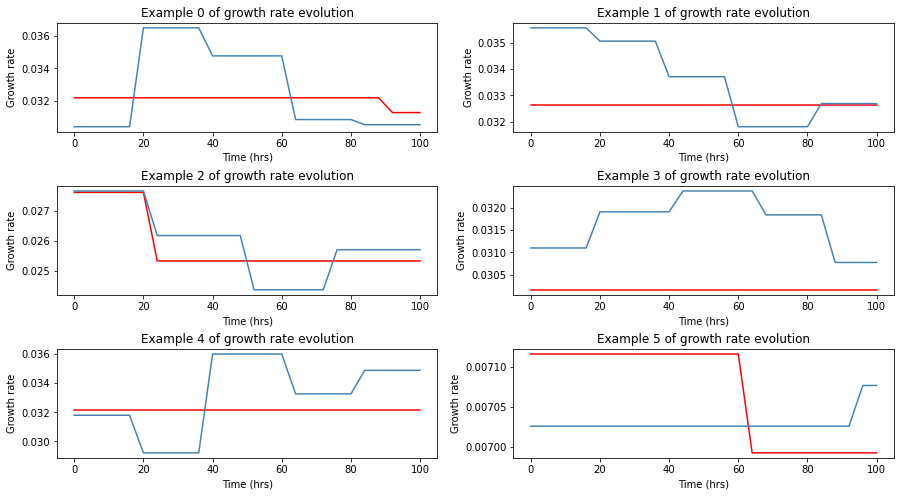

In [177]:
replicates = [sim_B_growth(growthR_init, time, dty_mix, dty_weights, mut_shape, sd_noise, 
                           constant_mut_rate, mutation_rate, seed=k) for k in range(nreplicats)]
growthR_sim_replicates = np.array(replicates)[:,0]
growthR_sim_noise_replicates = np.array(replicates)[:,1]

fig, ax = plt.subplots(3,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
for i in range(6) :
    ax[i//2,i%2].plot(time, growthR_sim_replicates[0,:,i], color="r")
    ax[i//2,i%2].plot(time, growthR_sim_noise_replicates[0,:,i], color="steelblue")
    ax[i//2,i%2].set(xlabel = "Time (hrs)", ylabel = "Growth rate", title = "Example "+str(i)+" of growth rate evolution")

In [178]:
def draw_log_log(wt,ximin,ximax,nbreaks_xi,tmax,ax,n_renorm=0,titre="",verbose=False):
    
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot = np.abs([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    if n_renorm > 0 :    # number of initial growth rate measures considered to renormalise
        tot = tot/np.median(tot[:n_renorm,:], axis=0)
    
    tot = np.log(tot)
        
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        if verbose : print("pente :",slope)
    # affichage:
    ax.plot(np.array(range(tmax))*4,tot)
    ax.grid()
    ax.legend(["xi="+str(round(xi,1)) for xi in Xi])
    ax.set(xlabel="t", ylabel="ln|Fu_t(xi)|", title=titre)

def draw_log_arg(wt,ximin,ximax,nbreaks_xi,tmax,n_renorm=0,titre="", verbose=False):
    
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot = np.array([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    if n_renorm > 0 :    # number of initial growth rate measures considered to renormalise
        tot = tot/np.median(tot[:n_renorm,:], axis=0)
    
    tot = np.angle(tot)
        
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        print("pente :",slope)
    # affichage:
    plt.plot(np.array(range(tmax))*4,tot)
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("arg[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

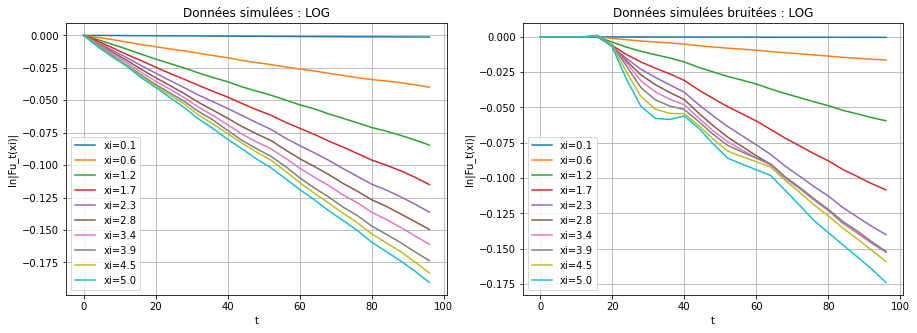

In [179]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
draw_log_log(growthR_sim_replicates[1],ximin=0.1,ximax=5,nbreaks_xi=10,tmax=exp_duration//4,ax=ax[0],n_renorm=1,titre="Données simulées : LOG")
draw_log_log(growthR_sim_noise_replicates[1],ximin=0.1,ximax=5,nbreaks_xi=10,tmax=exp_duration//4,ax=ax[1],n_renorm=1,titre="Données simulées bruitées : LOG")

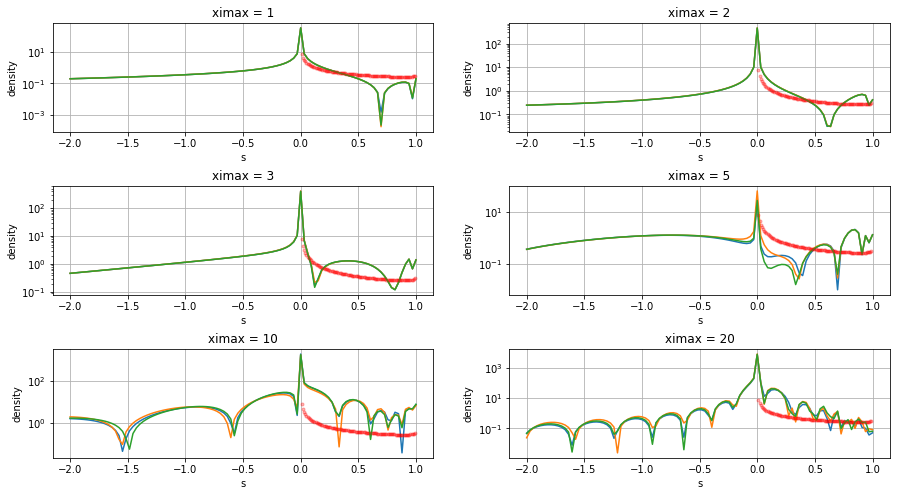

In [180]:
fig, ax = plt.subplots(3,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)

for growthR_sim_noise_i in growthR_sim_replicates:
    dfeln=[]
    dfe=[]
    for i,ximax in enumerate([1,2,3,5,10,20]):
        dfeln+=[get_dfe(growthR_sim_noise_i,lnx,lambd,ximin=-ximax,ximax=ximax,nbreaks_xi=100,tmax=exp_duration//4)]
        dfe+=[dfeln[i]/x]
        ax[i//2,i%2].plot(x,np.abs(dfe[i]))
        ax[i//2,i%2].plot(zar,dfe_reelle_sim,'.', c="r", alpha=1/(3*nreplicats))
        ax[i//2,i%2].grid()
        ax[i//2,i%2].set(title="ximax = " + str(ximax), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

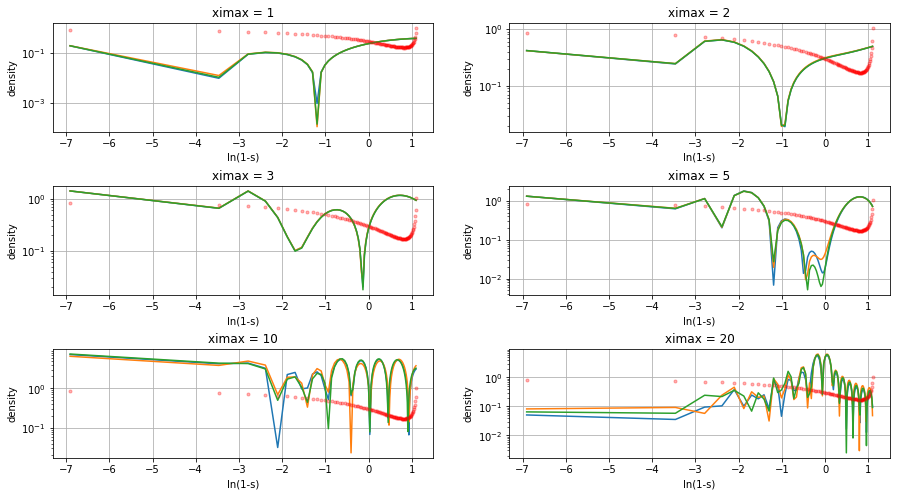

In [181]:
fig, ax = plt.subplots(3,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)

for growthR_sim_noise_i in growthR_sim_replicates:
    dfeln=[]
    dfe=[]
    for i,ximax in enumerate([1,2,3,5,10,20]):
        dfeln+=[get_dfe(growthR_sim_noise_i,lnx,lambd,ximin=-ximax,ximax=ximax,nbreaks_xi=100,tmax=exp_duration//4)]
        #dfe+=[dfeln[i]/x]
        ax[i//2,i%2].plot(lnx,np.abs(dfeln[i]))
        ax[i//2,i%2].plot(lnx,np.exp(x)*dfe_reelle_sim,'.', c="r", alpha=1/(3*nreplicats))
        ax[i//2,i%2].grid()
        ax[i//2,i%2].set(title="ximax = " + str(ximax), yscale='log', xlabel="ln(1-s)", ylabel="density")
    
plt.show()

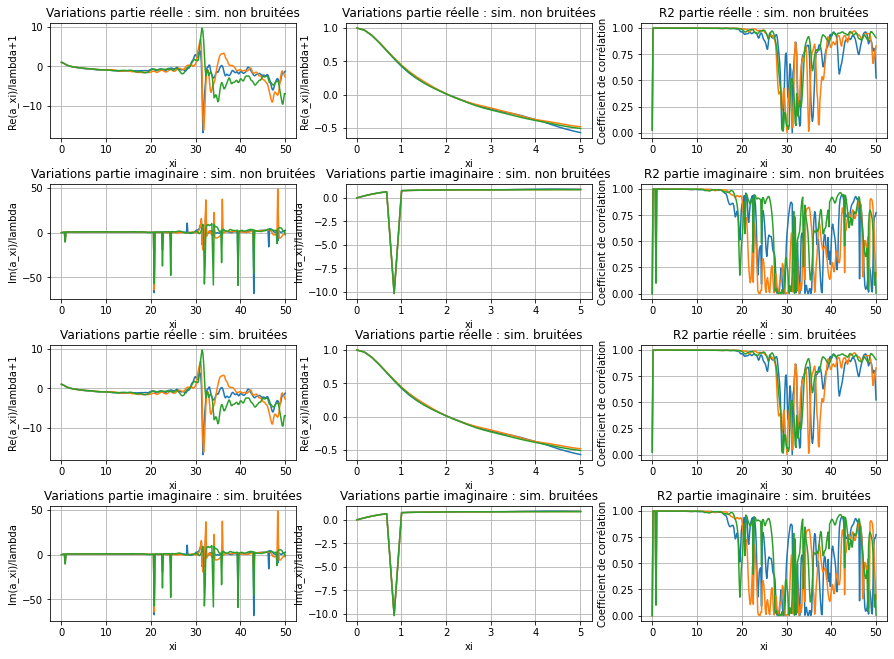

In [182]:
ximin=0
ximax=50
nbreaks_xi=300

xi_cut = int(5*nbreaks_xi/ximax+1)    # Zoom sur [0,5]

im, ax = plt.subplots(4,3, figsize=(15,11))
im.subplots_adjust(hspace=0.4)

for growthR_sim_i in growthR_sim_replicates:
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(growthR_sim_i,ximin,ximax,nbreaks_xi,tmax=exp_duration//4).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    
    ax[0,0].plot(Xi,1+np.real(a_xi)/lambd)
    ax[1,0].plot(Xi,np.imag(a_xi)/lambd)
    ax[0,1].plot(Xi[:xi_cut],1+np.real(a_xi[:xi_cut])/lambd)
    ax[1,1].plot(Xi[:xi_cut],np.imag(a_xi[:xi_cut])/lambd)
    ax[0,2].plot(Xi,ReFit**2)
    ax[1,2].plot(Xi,ImFit**2)

for growthR_sim_noise_i in growthR_sim_replicates:
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(growthR_sim_noise_i,ximin,ximax,nbreaks_xi,tmax=exp_duration//4).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    
    ax[2,0].plot(Xi,1+np.real(a_xi)/lambd)
    ax[3,0].plot(Xi,np.imag(a_xi)/lambd)
    ax[2,1].plot(Xi[:xi_cut],1+np.real(a_xi[:xi_cut])/lambd)
    ax[3,1].plot(Xi[:xi_cut],np.imag(a_xi[:xi_cut])/lambd)
    ax[2,2].plot(Xi,ReFit**2)
    ax[3,2].plot(Xi,ImFit**2)

[[axij.grid() for axij in axi] for axi in ax]
ax[0,0].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. non bruitées")
ax[1,0].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. non bruitées")
ax[0,1].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. non bruitées")
ax[1,1].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. non bruitées")
ax[0,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie réelle : sim. non bruitées")
ax[1,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie imaginaire : sim. non bruitées")
ax[2,0].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. bruitées")
ax[3,0].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. bruitées")
ax[2,1].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. bruitées")
ax[3,1].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. bruitées")
ax[2,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie réelle : sim. bruitées")
ax[3,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie imaginaire : sim. bruitées")
plt.show()

$\to$ il y a toujours du bruit, mais qui semble plus facile à gérer (par exemple, en comparant à la médiane).

# Comparaison différentes DFE

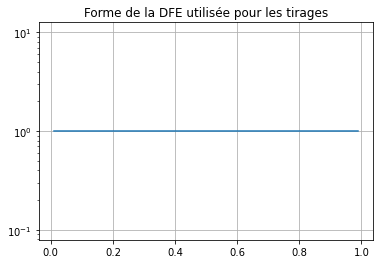

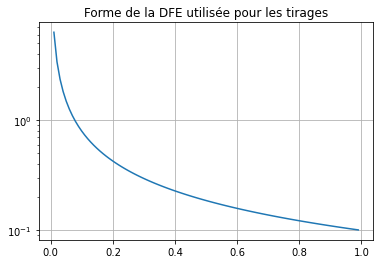

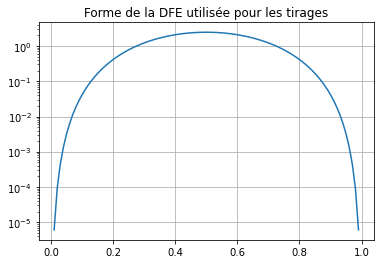

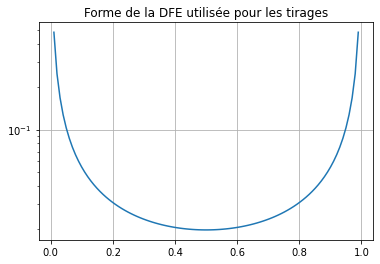

In [183]:
parameters = [(1,1), (0.1,1), (5,5), (0.01,0.01)]

for alpha,beta in parameters:
    zar=np.linspace(0.01,0.99,100)
    plt.yscale('log')
    plt.grid()
    plt.title("Forme de la DFE utilisée pour les tirages")
    dfe_reelle_sim=[z**(alpha-1)*(1-z)**(beta-1)*ssp.gamma(alpha+beta)/(ssp.gamma(alpha)*ssp.gamma(beta)) for z in zar]
    plt.plot(zar,dfe_reelle_sim)
    plt.show()

In [184]:
dfe, growthR_sim_noise_DFEs, sim_DFEs = [], [], []

for i,pars in enumerate(parameters):
    alpha, beta = pars
    dty_mix = (np.random.beta(alpha, beta, mut_shape), np.ones(mut_shape))
    dty_weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité
    sim_DFEs.append([z**(alpha-1)*(1-z)**(beta-1)*ssp.gamma(alpha+beta)/(ssp.gamma(alpha)*ssp.gamma(beta)) for z in zar])
    growthR_sim_noise_DFEs.append(sim_B_growth(growthR_init, time, dty_mix, dty_weights, mut_shape, sd_noise, constant_mut_rate, mutation_rate, seed=0)[1])

<ipython-input-176-e1589fdefa8c>:60: RuntimeWarning: divide by zero encountered in true_divide
  exponential_intervals = np.random.exponential(1/mutation_rate_t)


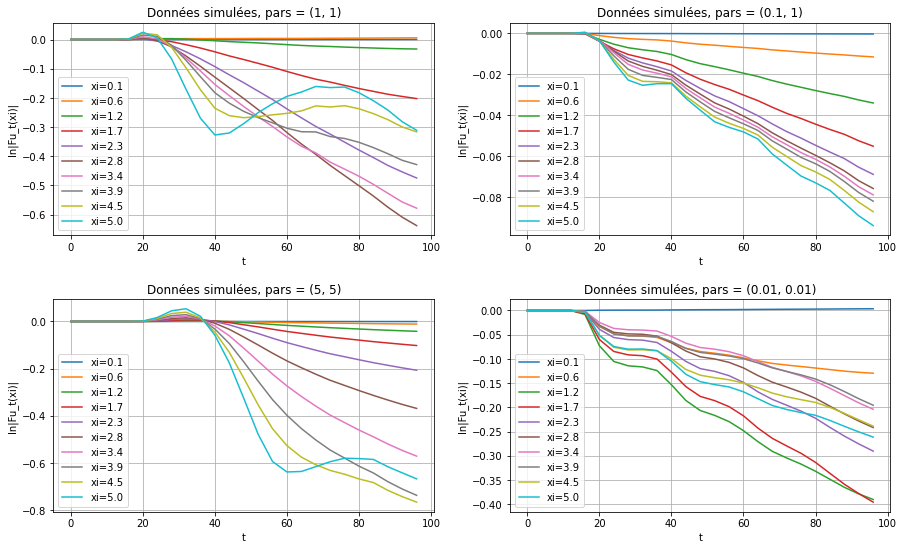

In [185]:
fig, ax = plt.subplots(2,2, figsize=(15,9))
fig.subplots_adjust(hspace=0.3)

for i,pars in enumerate(parameters):
    draw_log_log(growthR_sim_noise_DFEs[i],ximin=0.1,ximax=5,nbreaks_xi=10,tmax=exp_duration//4,ax=ax[i//2,i%2],n_renorm=1,titre="Données simulées, pars = " + str(pars))
    
plt.show()

Choix du tmax le plus élevé avec des droites encore bien formées :

In [186]:
#tmax_choice = np.array([250, 1000, 300, 250])
tmax_choice = np.array([100])

IndexError: index 1 is out of bounds for axis 0 with size 1

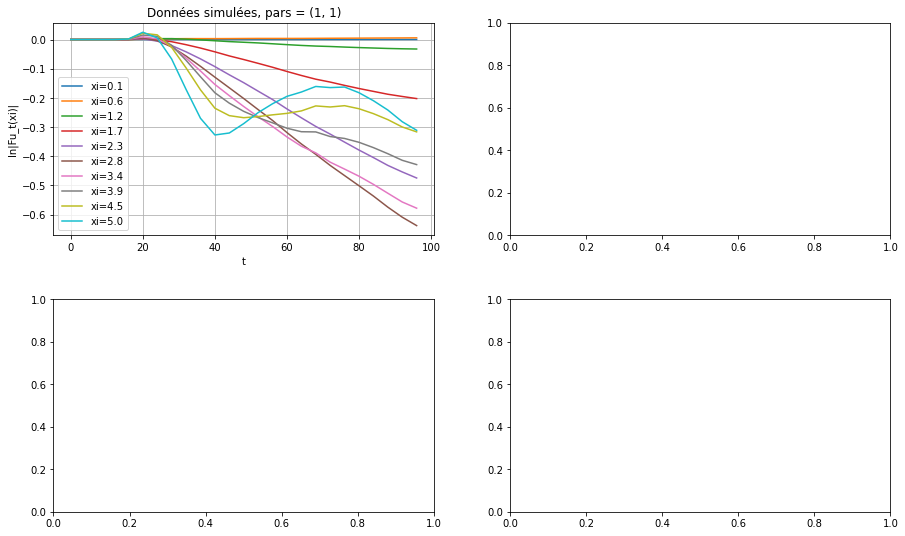

In [187]:
fig, ax = plt.subplots(2,2, figsize=(15,9))
fig.subplots_adjust(hspace=0.3)

for i,pars in enumerate(parameters):
    draw_log_log(growthR_sim_noise_DFEs[i],ximin=0.1,ximax=5,nbreaks_xi=10,tmax=tmax_choice[i]//4,ax=ax[i//2,i%2],n_renorm=1,titre="Données simulées, pars = " + str(pars))
    
plt.show()

In [ ]:
ximin=0
ximax=10
nbreaks_xi=100

fig, ax = plt.subplots(2,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.3)

for i,pars in enumerate(parameters):
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(growthR_sim_noise_DFEs[i],ximin,ximax,nbreaks_xi,tmax=tmax_choice[i]//4).T
    
    ax[i//2,i%2].plot(Xi,ReFit**2, label="Partie réelle")
    ax[i//2,i%2].plot(Xi,ImFit**2, label="Partie imaginaire")
    ax[i//2,i%2].legend(loc='upper right')
    ax[i//2,i%2].set(title="Qualité d'ajustement de la régression", xlabel="xi", ylabel="Coefficient de corrélation")
    
plt.show()

Choix du xi le plus élevé maintenant une bonne adéquation :

In [ ]:
ximax_choice = [2.3, 10, 4, 8.5]

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)

for i,pars in enumerate(parameters):    
    dfeln = get_dfe(growthR_sim_noise_DFEs[i],lnx,lambd,ximin=0,ximax=ximax_choice[i],nbreaks_xi=100,tmax=tmax_choice[i]//4)
    dfe.append(dfeln/x)
    
    ax[i//2,i%2].plot(x,np.abs(dfe[i]))
    ax[i//2,i%2].plot(zar,sim_DFEs[i],'.', c="r", alpha=1/(3*nreplicats))
    ax[i//2,i%2].grid()
    ax[i//2,i%2].set(title="(alpha,beta) = " + str(pars), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

### Comparaisons

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)

for i,pars in enumerate(parameters):    
    dfeln = get_dfe(growthR_sim_noise_DFEs[i],lnx,lambd,ximin=0,ximax=ximax_choice[i],nbreaks_xi=100,tmax=tmax_choice[i]//4)
    dfe.append(dfeln/x)
    
    ax[i//2,i%2].plot(x,np.abs(dfe[i])/np.abs(dfe[1]))
    ax[i//2,i%2].plot(zar,sim_DFEs[i],'.', c="r", alpha=1/(3*nreplicats))
    ax[i//2,i%2].grid()
    ax[i//2,i%2].set(title="(alpha,beta) = " + str(pars), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

# Bruit au cours du temps

In [ ]:
replicates = [sim_B_growth(growthR_init, time, dty_mix, dty_weights, mut_shape, sd_noise, 
                           constant_mut_rate, mutation_rate, seed=k) for k in range(nreplicats)]
growthR_sim_replicates = np.array(replicates)[:,0]
growthR_sim_noise_replicates = np.array(replicates)[:,1]

fig, ax = plt.subplots(3,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
for i in range(6) :
    ax[i//2,i%2].plot(time, growthR_sim_replicates[0,:,i], color="r")
    ax[i//2,i%2].plot(time, growthR_sim_noise_replicates[0,:,i], color="steelblue")
    ax[i//2,i%2].set(xlabel = "Time (hrs)", ylabel = "Growth rate", title = "Example "+str(i)+" of growth rate evolution")

In [ ]:
#plt.plot(pd.DataFrame(noise[1]).rolling(10).median())

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
noise = growthR_sim_noise_replicates/growthR_sim_replicates
noise[noise==np.inf]=np.nan
[ax.plot(time, np.nanstd(noise_rep, axis=1), alpha=2/len(noise)) for noise_rep in noise]
ax.set(xlabel="Temps (min)", ylabel="Écart-type du bruit de mesure")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
noise = growthR_sim_noise_replicates/growthR_sim_replicates
noise[noise==np.inf]=np.nan
[ax.plot(time, pd.DataFrame(np.nanstd(noise_rep, axis=1)).rolling(30).mean(), alpha=2/len(noise)) for noise_rep in noise]
ax.set(xlabel="Temps (min)", ylabel="Écart-type du bruit de mesure")
plt.show()

# Norme $L^1$

In [ ]:
def cdf_l1(dist1,dist2,corr,tronc):
    cdf1=np.cumsum(dist1[1+tronc:])
    cdf2=np.cumsum(dist2[1+tronc:])
    if(len(cdf1)!=len(cdf2)):
        print("Attention: longueurs différentes",len(cdf1),len(cdf2))
    return np.sum([np.abs(corr*cdf1[i]-cdf2[i]) for i in range(len(cdf1))])*(xmax_reel-xmin_reel)/len(x)

In [ ]:
fig, ax = plt.subplots(6,1, figsize=(15,12))
fig.subplots_adjust(hspace=0.7)
dfeln=[]
dfe=[]
for i,ximax in enumerate([1,2,3,5,10,20]):
    dfeln+=[get_dfe(growthR_sim_replicates[0],lnx,lambd,ximin=0,ximax=ximax,nbreaks_xi=100,tmax=100)]
    dfe+=[[dfeln[i][j]/x[j] for j in range(len(x))]]
    ax[i].plot(x,np.abs(dfe[i]))
    ax[i].plot(zar,dfe_reelle_sim,'.')
    ax[i].grid()
    ax[i].set(title="ximax = " + str(ximax), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

In [ ]:
print("Norme tronquée de la vraie DFE :",cdf_l1([0]*100,dfe_reelle_sim,corr=1,tronc=20))
for i in range(6):
    print("Distance tronquée entre la ",i+1,"e DFE estimée et la vraie DFE :",cdf_l1(dfe[i],dfe_reelle_sim,corr=1,tronc=20))

# NB: terme corr: correction pour que les dfe comparées aient à peu près la même échelle.
# tronc: on tronque le début car on ne repère pas le gros pic très fin passe mal à la discrétisation